## Fuel Consumption Prediction

Outline of the project:

* [Introduction](#1)
* [Packages & Libraries](#2)
* [Import Dataset](#3)
* [Missing Values](#4)
* [Exploratory Data Analysis (EDA)](#5)
* [Outlier Analysis](#6)
* [Feature Engineering](#7)
    * [Skewness Check](#8)
    * [One Hot Encoding](#9)
* [Data Preprocessing](#10)
    * [Train Test Split](#11)
    * [Standardization](#12)
* [Model](#13)
    * [Linear Regression](#14)
    * [Regularization 1: Ridge Regression](#15)
    * [Regularization 2: Lasso Regression](#16)
    * [Regularization 3: ElasticNet](#17)
    * [XGBoost](#18)
    * [Averaging Models](#19)

<a id = "1"></a>
### Introduction
<img src="http://media.flexdealer.com/blog/on1010/images/featured-image-822.jpg">

Source: [https://cocolevio.com/how-to-predict-car-fuel-efficiency-using-machine-learning/]

The automotive industry is extremely competitive. With increasing fuel prices and picky consumers, automobile makers are constantly optimizing their processes to increase fuel efficiency. But, what if you could have a reliable estimator for a car’s mpg given some known specifications about the vehicle? Then, you could beat a competitor to market by both having a more desirable vehicle that is also more efficient, reducing wasted R&D costs and gaining large chunks of the market.

In this kernel, I will apply a prediction app using auto-mpg dataset. The app and the data used is very easy to understand. I will explain them on 'import dataset' section. Before training linear regression model I will analyse missing values and outliers. Then feature engineering step come and this step I will check skewness for each numerical variables' distributions. For categorical features that have more than two labels I will encode the features by one hot encoding. In data preprocessing stage, I will prepare data for machine learning model via splitting data into train and test. To avoid bias against the features that have bigger values relative to others and to bring features to the same space, standardization is very important term. In modelling part, firstly I will perform a linear regression model via statmodels library. To increase model's performance, regularization techniques such as ridge regression, lasso regression and elasticnet. Finally, I will finish the app using XGBoost and averaging models.

<a id = "2"></a>
### Packages & Libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm, skew

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

<a id = "3"></a>
### Import Dataset

**About data:**

Number of Instances: 398
Number of Attributes: 9 including the class attribute

Attribute Information:

* mpg: continuous
* cylinders: multi-valued discrete
* displacement: continuous
* horsepower: continuous
* weight: continuous
* acceleration: continuous
* model year: multi-valued discrete
* origin: multi-valued discrete
* car name: string (unique for each instance)

In [2]:
data = pd.read_csv("../input/autompg-dataset/auto-mpg.csv", na_values = '?')
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [3]:
data.drop(["car name"], axis = 1, inplace = True)
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1


'mpg' is the target column

In [4]:
data = data.rename(columns = {'mpg' : 'target'})
data.head(3)

,target,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1


In [5]:
data.shape

(398, 8)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   target        398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 25.0 KB


In [7]:
describe = data.describe()
describe

,target,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


<a id = "4"></a>
### Missing Values

In [8]:
data.isna().sum()

target          0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
dtype: int64

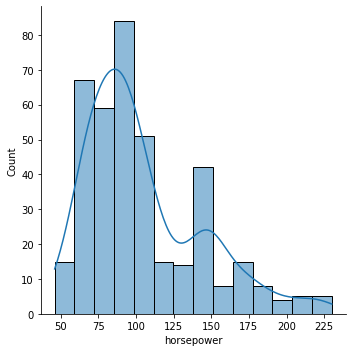

In [9]:
# plot before filling missing values
sns.displot(data["horsepower"], kde = True)

In [10]:
data["horsepower"] = data["horsepower"].fillna(data['horsepower'].mean())
data.isna().sum()

target          0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
dtype: int64

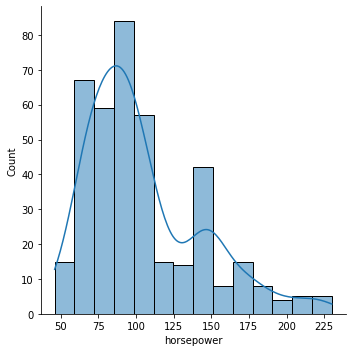

In [11]:
# plot after missing value imputation with horsepower mean
sns.displot(data = data["horsepower"], kde = True)

<a id = "5"></a>
### Exploratory Data Analysis

Text(0.5, 1.0, 'Correlation Between Features (Threshold: 0.75)')

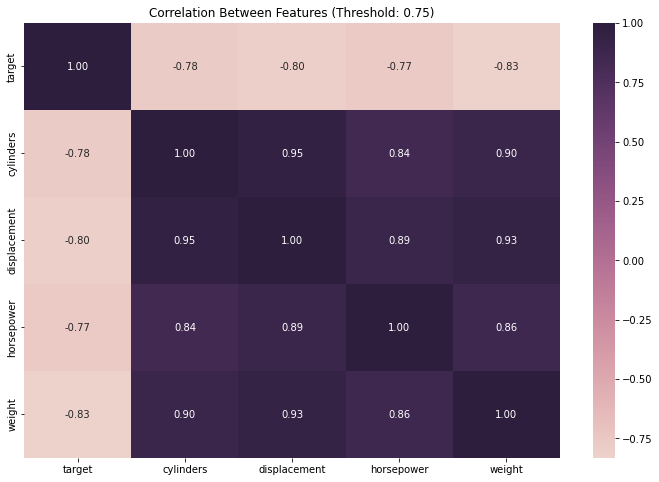

In [12]:
corr_matrix = data.corr()

threshold = 0.75
filter_ = np.abs(corr_matrix["target"]) > threshold
corr_features = corr_matrix.columns[filter_].tolist()

plt.figure(figsize = (12, 8))
sns.heatmap(data[corr_features].corr(), annot = True, cmap = sns.cubehelix_palette(as_cmap=True), fmt = ".2f")
plt.title("Correlation Between Features (Threshold: {})".format(threshold))

**Multicollinearity:**
* Multicollinearity is a statistical concept where several independent variables in a model are correlated.
* Two variables are considered to be perfectly collinear if their correlation coefficient is +/- 1.0.
* Multicollinearity among independent variables will result in less reliable statistical inferences.
* It is better to use independent variables that are not correlated or repetitive when building multiple regression models that use two or more variables.
* The existence of multicollinearity in a data set can lead to less reliable results due to larger standard errors.

Source: [https://www.investopedia.com/terms/m/multicollinearity.asp#:~:text=Multicollinearity%20is%20a%20statistical%20concept,in%20less%20reliable%20statistical%20inferences.]

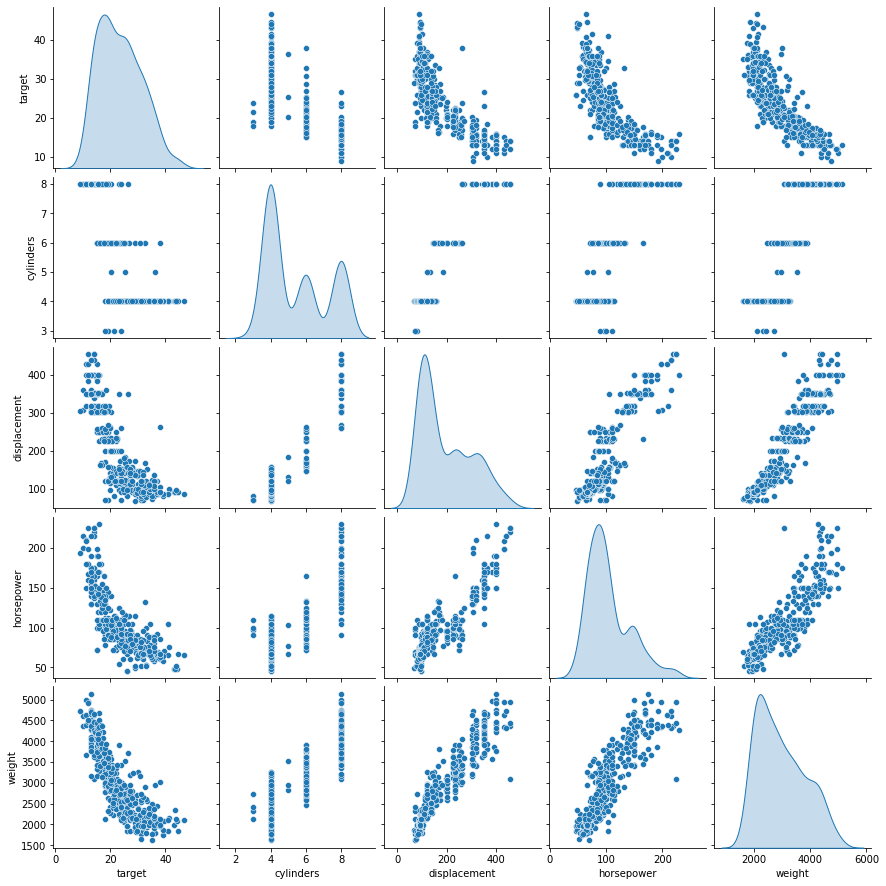

In [13]:
# Pairwise Relationship of Highly Correlated Features with Target in the Dataset
sns.pairplot(data[corr_features], diag_kind="kde")

Cylinders and origin can be categorical

Text(0.5, 1.0, 'Number of Vehicle By Cylinders')

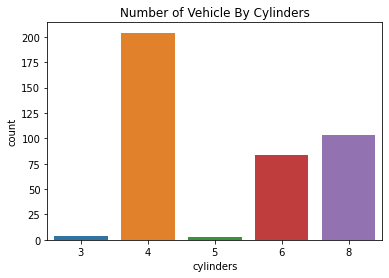

In [14]:
plt.figure()
sns.countplot(data["cylinders"])
plt.title("Number of Vehicle By Cylinders")

Text(0.5, 1.0, 'Number of Vehicle By Origin')

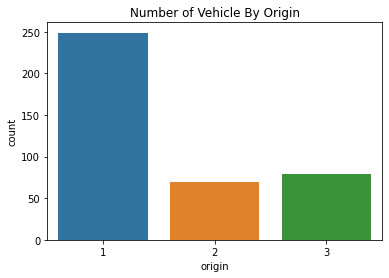

In [15]:
plt.figure()
sns.countplot(data["origin"])
plt.title("Number of Vehicle By Origin")

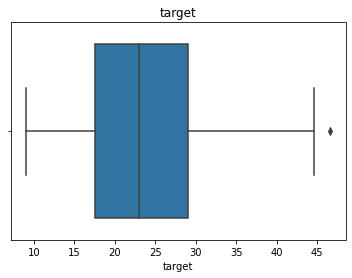

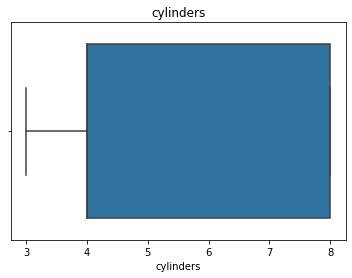

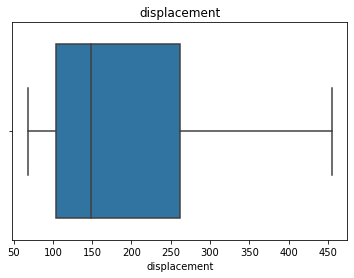

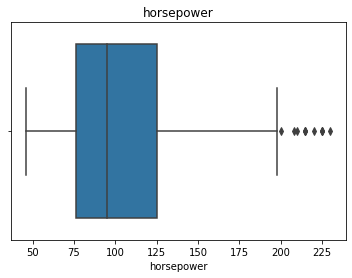

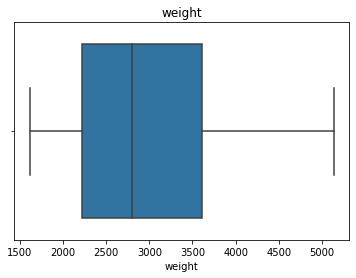

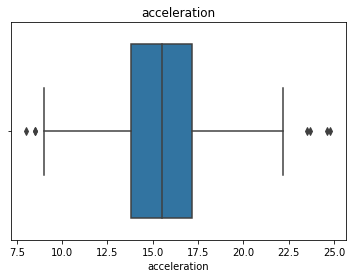

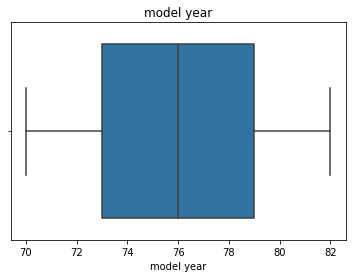

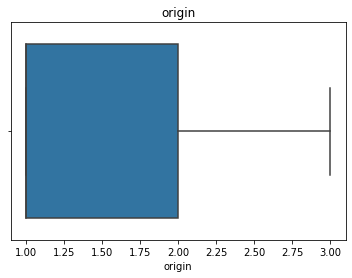

In [16]:
# box plots for each columns
for c in data.columns:
    plt.figure()
    sns.boxplot(x = c, data = data, orient = "h")
    plt.title(c)

outliers: horsepower and acceleration

<a id = "6"></a>
### Outlier Analysis
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Boxplot_vs_PDF.svg/375px-Boxplot_vs_PDF.svg.png">

The interquartile range is a measure of where the “middle fifty” is in a data set. Where a range is a measure of where the beginning and end are in a set, an interquartile range is a measure of where the bulk of the values lie. That’s why it’s preferred over many other measures of spread when reporting things like school performance or SAT scores.

The interquartile range formula is the first quartile subtracted from the third quartile:

**IQR = Q3 – Q1**

I use the threshold 2 instead of 1.5 because of avoiding too much data lose.

In [17]:
horsepower_desc = describe["horsepower"]
horsepower_desc

count    392.000000
mean     104.469388
std       38.491160
min       46.000000
25%       75.000000
50%       93.500000
75%      126.000000
max      230.000000
Name: horsepower, dtype: float64

In [18]:
# horsepower iqr filtering

thr = 2

q3_hp = horsepower_desc[6]
q1_hp = horsepower_desc[4]
IQR_hp = q3_hp - q1_hp
top_limit_hp = q3_hp + thr*IQR_hp
bottom_limit_hp = q1_hp - thr*IQR_hp
filter_hp_bottom = bottom_limit_hp < data["horsepower"]
filter_hp_top = data["horsepower"] < top_limit_hp
filter_hp = filter_hp_bottom & filter_hp_top

data = data[filter_hp]
data.head()

,target,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1


In [19]:
# acceleration iqr filtering
acceleration_desc = describe["acceleration"]


thr = 2

q3_acc = acceleration_desc[6]
q1_acc = acceleration_desc[4]
IQR_acc = q3_acc - q1_acc
top_limit_acc = q3_acc + thr*IQR_acc
bottom_limit_acc = q1_acc - thr*IQR_acc
filter_acc_bottom = bottom_limit_acc < data["acceleration"]
filter_acc_top = data["acceleration"] < top_limit_acc
filter_acc = filter_acc_bottom & filter_acc_top

data = data[filter_acc]
data.head()

,target,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1


In [20]:
data.shape

(395, 8)

Three of outlier is cleaned from data

<a id = "7"></a>
### Feature Engineering
<a id = "8"></a>
#### Skewness Check

<img src="https://www.biologyforlife.com/uploads/2/2/3/9/22392738/c101b0da6ea1a0dab31f80d9963b0368_orig.png" height = 200 width = 700>

Is data normally distributed or not?

Skewness is a measurement of the distortion of symmetrical distribution or asymmetry in a data set. Skewness is demonstrated on a bell curve when data points are not distributed symmetrically to the left and right sides of the median on a bell curve.

* A skewness value of 0 in the output denotes a symmetrical distribution of values in row 1.
* A negative skewness value in the output indicates an asymmetry in the distribution corresponding to row 2 and the tail is larger towards the left hand side of the distribution.
* A positive skewness value in the output indicates an asymmetry in the distribution corresponding to row 3 and the tail is larger towards the right hand side of the distribution.

<AxesSubplot:xlabel='target', ylabel='Density'>

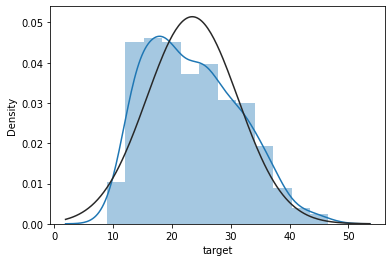

In [21]:
# target dependent variable
sns.distplot(data.target, fit=norm)

In [22]:
(mu, sigma) = norm.fit(data["target"])
print("mu: {}, sigma = {}".format(mu, sigma))

mu: 23.472405063291134, sigma = 7.756119546409932


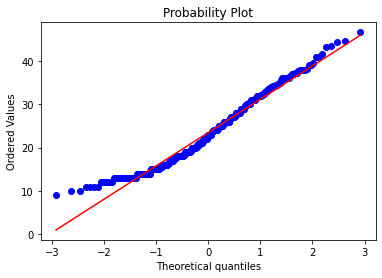

In [23]:
## QQ plot
plt.figure()
stats.probplot(data["target"], plot = plt)
plt.show()

<AxesSubplot:xlabel='target', ylabel='Density'>

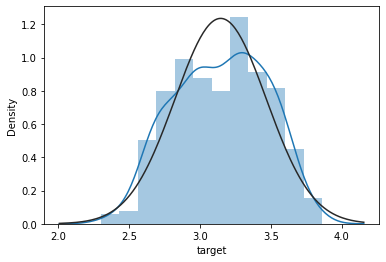

In [24]:
# log transformation
data["target"] = np.log1p(data["target"])

# distribution after log transformation
plt.figure()
sns.distplot(data.target, fit=norm)

In [25]:
# mean and standard deviation after log transformation
(mu, sigma) = norm.fit(data["target"])
print("mu: {}, sigma = {}".format(mu, sigma))

mu: 3.146474056830183, sigma = 0.3227569103044822


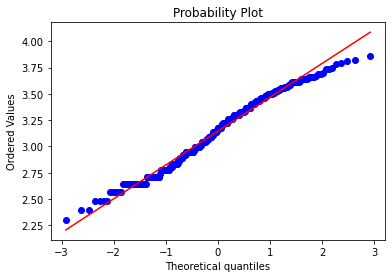

In [26]:
## QQ plot after log transformation
plt.figure()
stats.probplot(data["target"], plot = plt)
plt.show()

In [27]:
# feature - independent variable
skewed_feats = data.apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
skewness = pd.DataFrame(skewed_feats, columns = ["skewed"])
skewness

,skewed
horsepower,1.067743
origin,0.923381
displacement,0.714682
weight,0.533226
cylinders,0.523374
acceleration,0.168986
model year,0.013098
target,-0.117687


<a id = "9"></a>
#### One Hot Encoding

In [28]:
data["cylinders"] = data["cylinders"].astype(str)
data["origin"] = data["origin"].astype(str)

data = pd.get_dummies(data)
data

,target,displacement,horsepower,weight,acceleration,model year,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,origin_1,origin_2,origin_3
0,2.944439,307.0,130.0,3504,12.0,70,0,0,0,0,1,1,0,0
1,2.772589,350.0,165.0,3693,11.5,70,0,0,0,0,1,1,0,0
2,2.944439,318.0,150.0,3436,11.0,70,0,0,0,0,1,1,0,0
3,2.833213,304.0,150.0,3433,12.0,70,0,0,0,0,1,1,0,0
4,2.890372,302.0,140.0,3449,10.5,70,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,3.332205,151.0,90.0,2950,17.3,82,0,1,0,0,0,1,0,0
393,3.332205,140.0,86.0,2790,15.6,82,0,1,0,0,0,1,0,0
395,3.496508,135.0,84.0,2295,11.6,82,0,1,0,0,0,1,0,0
396,3.367296,120.0,79.0,2625,18.6,82,0,1,0,0,0,1,0,0


<a id = "10"></a>
### Data Preprocessing
<a id = "11"></a>
#### Train Test Split

In [29]:
y = data.target
x = data.drop(["target"], axis = 1)

In [30]:
test_size = 0.9
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = test_size, random_state = 42)

<a id = "12"></a>
#### Standardization

In [31]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<a id = "13"></a>
### Model
<a id = "14"></a>
#### Linear Regression